In [1]:
import os
import re
import pandas as pd
from pandasql import sqldf
import numpy as np

pysqldf = lambda q: sqldf(q, globals())

In [2]:
year_duration = 30

In [3]:
month_mapping = {
    "Jun":6,
    "May":5,
    "Apr":4,
    "Mar":3,
    "Feb":2,
    "Jan":1,
    "Dec":12,
    "Nov":11,
    "Oct":10,
    "Sep":9,
    "Aug":8,
    "Jul":7,
    }

def date_normalize(date):
    try:
        result = re.search(r'(?P<m>\d+)\/(?P<d>\d+)\/(?P<y>\d+)', date).groupdict()
        output = '%04d-%02d-%02d'%(
            int(result['y']),
            int(result['m']),
            int(result['d']),
            )
        return output
    except:
        pass
    try:
        parsing_result = re.search(r'(?P<m>[A-z]{3}) (?P<d>\d{2}) (?P<y>\d{4})', date).groupdict()
        parsing_result['m'] = month_mapping[parsing_result['m']]
        parsing_result['m'] = '%02d'%(parsing_result['m'])
        return('%s-%s-%s'%(
            parsing_result['y'],
            parsing_result['m'],
            parsing_result['d'],
            ))
    except:
        pass
    return date

date = '9/17/2015'
date = 'Jun 14 2022'

date_normalize(
    date,
    )

'2022-06-14'

<AxesSubplot:xlabel='Date'>

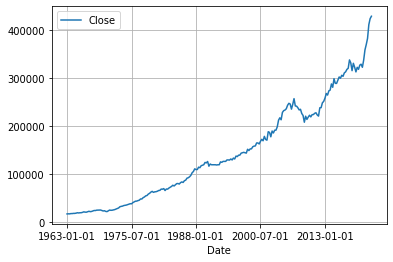

In [4]:
property_data = pd.read_csv(
    'history/MSPUS.csv',
    )

property_data['Date'] = property_data['Date'].apply(date_normalize)
property_data['Month'] = property_data['Date'].apply(lambda x:x.split('-')[0]+'-'+x.split('-')[1])

property_data['Close'] = property_data['Close'].apply(lambda x: float(x))
property_data['id'] = property_data.index

property_data.plot(x ='Date', y=[
    'Close', 
    ], grid = True)

<AxesSubplot:xlabel='Date'>

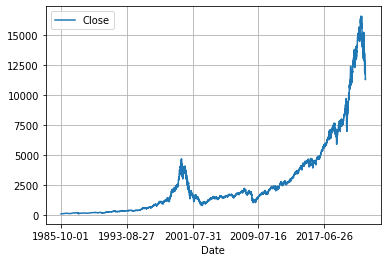

In [5]:
nasdaq_data = pd.read_csv(
    'history/NDX.csv',
    )

nasdaq_data['Date'] = nasdaq_data['Date'].apply(date_normalize)
nasdaq_data['Month'] = nasdaq_data['Date'].apply(lambda x:x.split('-')[0]+'-'+x.split('-')[1])

nasdaq_data['Close'] = nasdaq_data['Close'].apply(lambda x: float(x))
nasdaq_data['id'] = nasdaq_data.index

nasdaq_data.plot(x ='Date', y=[
    'Close', 
    ], grid = True)

In [6]:
nasdaq_data_month = pysqldf(u"""
    select Month, avg(Close) as Close
    from nasdaq_data
    group by Month
    """)

In [7]:
compare_date = pysqldf(u"""
    select p.Date, 
    p.Close as Property_Price,
    n.Close as NQ100_Price
    from property_data as p
    left join nasdaq_data_month as n on n.Month = p.Month
    where p.Date >= '1985-10-01'
    order by p.Date asc
    """)

compare_date['id'] = compare_date.index

In [8]:
window_size = year_duration*4

In [9]:
compare_date_now_old = pysqldf(u"""
    select now.*,
    old.Date as Date_old,
    old.Property_Price as Property_Price_old,
    old.NQ100_Price as NQ100_Price_old    
    from compare_date as now
    join compare_date as old
    on old.id + {} = now.id
    """.format(window_size))

In [10]:
Stock2Property = pysqldf(u"""
    select *,
    Property_Price/Property_Price_old as Property_Rate,
    ((Property_Price/Property_Price_old)*5 - 4*(1-{}/30)) as Leveraged_Property_Ratio,
    NQ100_Price/NQ100_Price_old as NQ100_Rate
    from compare_date_now_old
    """.format(year_duration))

In [11]:
Stock2Property = pysqldf(u"""
    select *,
    NQ100_Rate/Property_Rate as Stock2Property,
    NQ100_Rate/Leveraged_Property_Ratio as Stock2Leveraged_Property    
    from Stock2Property
    """)

<AxesSubplot:xlabel='Date'>

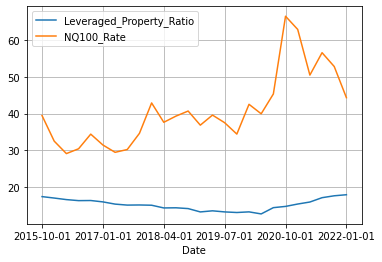

In [12]:
Stock2Property.plot(x ='Date', y=[
    'Leveraged_Property_Ratio', 
    'NQ100_Rate', 
    ], grid = True)

In [13]:
np.std(Stock2Property['Leveraged_Property_Ratio'])

1.5078745670496123

In [14]:
np.std(Stock2Property['NQ100_Rate'])

9.754794556652426

<AxesSubplot:>

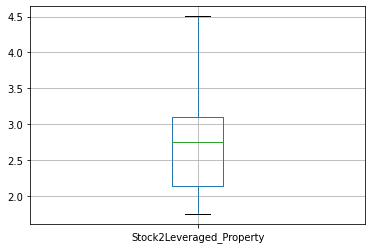

In [15]:
Stock2Property.boxplot(column=['Stock2Leveraged_Property']) 

In [16]:
nq100_to_leveraged_property_ratio = Stock2Property['Stock2Leveraged_Property'].median()

print('Nasdaq to Leveraged Property Ratio:\t%0.4f'%(nq100_to_leveraged_property_ratio))

Nasdaq to Leveraged Property Ratio:	2.7556


In [17]:
nq100_to_property_ratio = Stock2Property['Stock2Property'].median()

print('Nasdaq to Property Ratio:\t%0.4f'%(nq100_to_property_ratio))

Nasdaq to Property Ratio:	13.7779


In [18]:
nq100_ratio = Stock2Property['NQ100_Rate'].median()

nq100_ratio_min = Stock2Property['NQ100_Rate'].min()

print('Nasdaq Ratio:\t%0.4f, min:\t%0.4f'%(nq100_ratio, nq100_ratio_min))

Nasdaq Ratio:	39.3840, min:	29.1220


In [21]:
leveraged_property_ratio = Stock2Property['Leveraged_Property_Ratio'].median()

leveraged_property_ratio_min = Stock2Property['Leveraged_Property_Ratio'].min()

print('Leveraged Property Ratio:\t%0.4f, min:\t%0.4f'%(leveraged_property_ratio, leveraged_property_ratio_min))

Leveraged Property Ratio:	15.1352, min:	12.7208


In [20]:
Property_Rate = Stock2Property['Property_Rate'].median()

print('Property Ratio:\t%0.4f'%(Property_Rate))

Property Ratio:	3.0270
